# NDReg

## Preface
I am completing this algorithms MD to the extent of my current knowledge. I will be meeting with Kwame on Tuesday 1/17 in order to fill in the gaps in my knowledge and obtain a more comprehensive understanding of the algorithm. 

## Algorithm
### Description
NDReg is an algorithm designed to calculate one or more coordinate transformations with the goal of aligning two images of the same scene. For our specific application, NDreg will be used to track specific synapses over time, such that stochastic statistics can be generated about the subject's synaptic activity.

### Inputs
- inImg_ds -> The image two be aligned
- refImage_ds -> The image which inImg_ds is being aligned to
- iterations -> The number of iterations to run the algorithm
- useMI -> Whether or not to use MI (Mutual Information)
- verbose -> Whether or not to print progress and debug data

### Outputs
- The parameters of an affine transform that maps the inImg_ds to the refImage_ds

### Function

In [3]:
####################################################
###PSEUDOCODE WILL GO HERE ONCE I MEET WITH KWAME###
####################################################

### Analysis
#### Qualitative Visualizations
I will display the input and base image to be passed to the register function, and the result of applying the register function's output to the input image.

#### Quantitative Score
I will use the following loss function (sum of squared errors) to evaluate the success of the algorithm:
$\Sigma_{voxels}L_2(inputImage[voxel] - baseImage[voxel])$

#### Summary Score
I will use the average percent reduction in squared error over a series of tests to summarize the quantitative performance of the algorithm.

#### Null Comparison
I will compare the results of the register function to a function which generates and applies a random rigid body transformation in order to demonstrate how well the algorithm performes compared to random guessing.



### Write Code

In [4]:
import sys
sys.path.insert(0, '../../../ndreg/')
import ndreg

def register(inImg, baseImg):
    return ndreg.imgAffineComposite(inImg,
                              baseImg,
                              iterations=200,
                              useMI=False,
                              verbose=False)

## Simulation
### Functionality Testing
NDReg functionality tests will be performed in order to verify that the register funciton is working as expected.

#### 1. Generate Data

In [5]:
refImg = ndreg.imgDownload('ara_ccf2')
refAnnoImg = ndreg.imgDownload('ara_ccf2', channel="annotation")
inImg = ndreg.imgDownload('eacker01', 'r', 5)

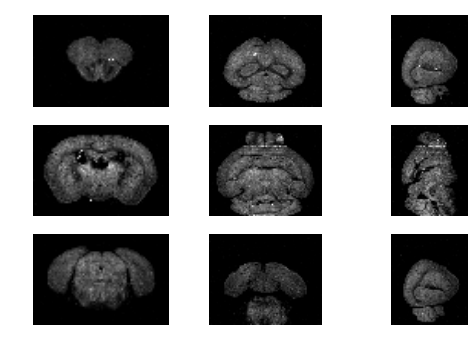

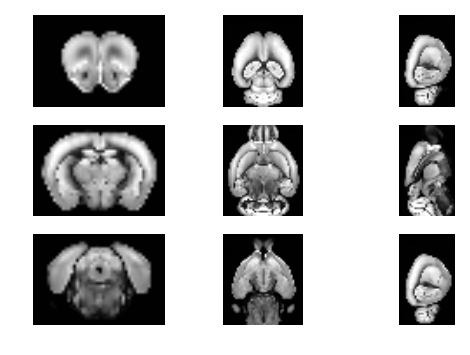

In [6]:
#reorient and rescale the test image
inImgReor = ndreg.imgReorient(inImg, 'lsp', 'rsa')
inImg_ds = ndreg.imgResample(inImgReor, spacing=[.25, .25, .25])
refImg_ds = ndreg.imgResample(refImg, spacing=[.25, .25, .25])

#display the images to be registered
ndreg.imgShow(inImg_ds, vmax=10000)
ndreg.imgShow(refImg_ds, vmax=500)

#### 2. Generate Results

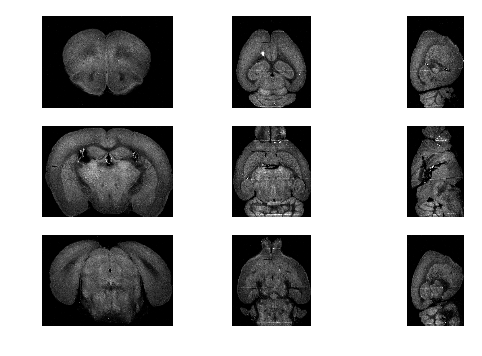

In [7]:
affine = register(inImg_ds, refImg_ds)
resultImage = ndreg.imgApplyAffine(inImgReor,
                                   affine,
                                   size=refImg.GetSize(),
                                   spacing=refImg.GetSpacing())
ndreg.imgShow(resultImage, vmax=10000)

#### 3. Analyze Results
The results of this functionality test are consistent with those of the NDReg documentation. I can now proceed to the validation testing phase. 

### Validation Testing
#### 1. Generate Data
The following code will generate two 100x100x100 volumes randomly populated with synapses and noise modeling that of the real world data, and then apply a random rigid body transformation to one of the volumes. The volumes will then be run thorugh the register algorithm in order to attemt to align them again.

In [8]:
import math
import numpy as np
import SimpleITK as itk
from random import randrange as rand
from random import uniform as floatRand
from affine import Affine

def generatePointSet():
    center = (rand(0, 99), rand(0, 99), rand(0, 99))
    toPopulate = []
    for z in range(-1, 2):
        for y in range(-1, 2):
            for x in range(-1, 2):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)               
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 100:
                        valid = False
                        
                if valid:
                    toPopulate.append(curPoint)
            
    return set(toPopulate)                       
   
def getTransform():
    #generate a random rigid body transform
    #error is assumed to be 5% rotationally
    #and laterally
    a = floatRand(-.075, .075)
    b = floatRand(-.075, .075)
    c = floatRand(-.075, .075)
    xt = floatRand(-2.5, 2.5)
    yt = floatRand(-2.5, 2.5)
    zt = floatRand(-2.5, 2.5)
    transform = np.stack([
        [math.cos(a)*math.cos(b), math.cos(a)*math.sin(b)*math.sin(c)-math.sin(a)*math.cos(c), math.cos(a)*math.sin(b)*math.cos(c)+math.sin(a)*math.sin(c), xt],
        [math.sin(a)*math.cos(b), math.sin(a)*math.sin(b)*math.sin(c)+math.cos(a)*math.cos(c), math.sin(a)*math.sin(b)*math.cos(c)-math.cos(a)*math.sin(c), yt],
        [-math.sin(b), math.cos(b)*math.sin(c), math.cos(b)*math.cos(c), zt],
        [0., 0., 0., 1.]
    ])
    return transform
    
    
def applyRigid(initialVolume, transform):
    rigidMatrix = np.zeros_like(initialVolume)    
    for z in range(initialVolume.shape[0]):
        for y in range(initialVolume.shape[1]):
            for x in range(initialVolume.shape[2]):
                new = np.dot(transform, [x, y, z, 1])
                try:
                    rigidMatrix[int(new[2])][int(new[1])][int(new[0])] = initialVolume[z][y][x]
                #if transformed place is out of bounds, dont deal with it
                except IndexError:
                        continue
    return rigidMatrix
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
        
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
      
    #convert numpy array to itk image
    itkVolume = itk.GetImageFromArray(noiseVolume)
    
    #perform a random rigid body transform to generate the second volume
    transform = getTransform()
    rigidMatrix = applyRigid(noiseVolume, transform)
    
    rigidVolume = itk.GetImageFromArray(rigidMatrix)
    return itkVolume, rigidVolume, transform

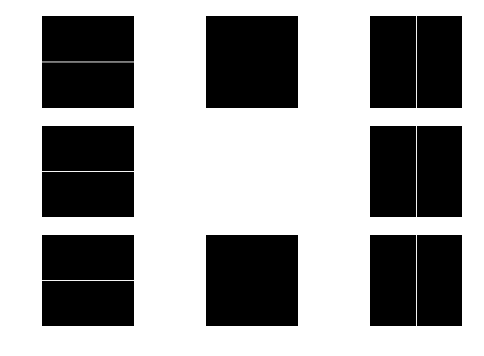

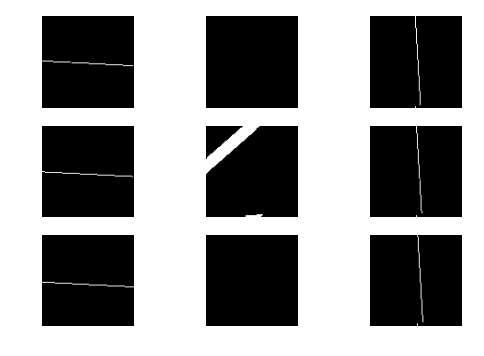

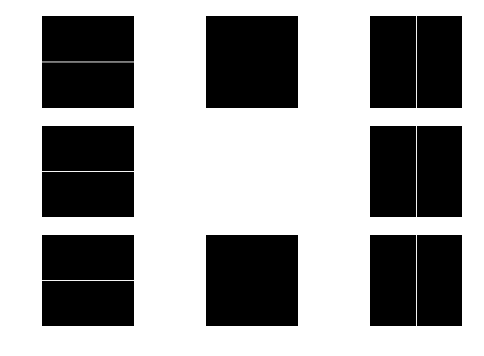

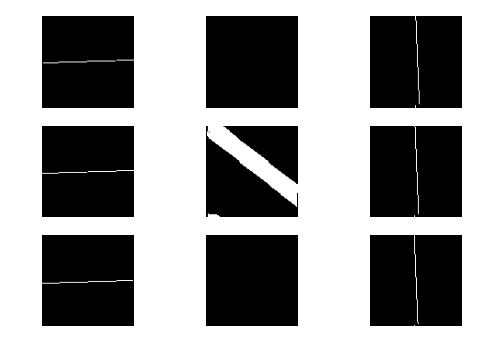

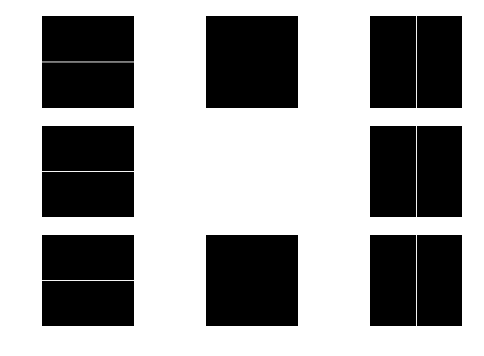

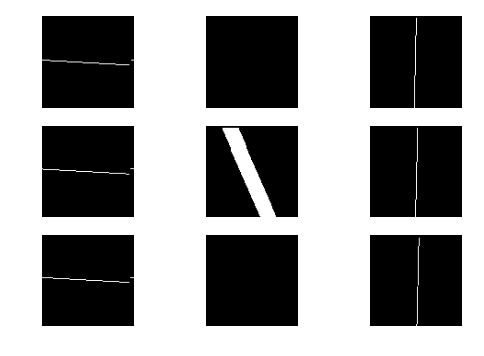

In [3]:
#a quick functionality test for the random rigid

for i in range(3):
    this = np.zeros((100, 100, 100))
    for x in range(0, 100):
        for z in range(0, 100):
            this[z][50][x] = 60000
    
    transform = getTransform()
    that = applyRigid(this, transform)   
    those = itk.GetImageFromArray(that)
    ndreg.imgShow(itk.GetImageFromArray(this), vmax=60000)
    ndreg.imgShow(those, vmax=60000)


Executing Test:  1
[[ 0.99702373 -0.03066098 -0.07073601 -1.22061544]
 [ 0.02912452  0.99931911 -0.02265142 -1.97716204]
 [ 0.07138236  0.02052385  0.99723785 -2.31698901]
 [ 0.          0.          0.          1.        ]]


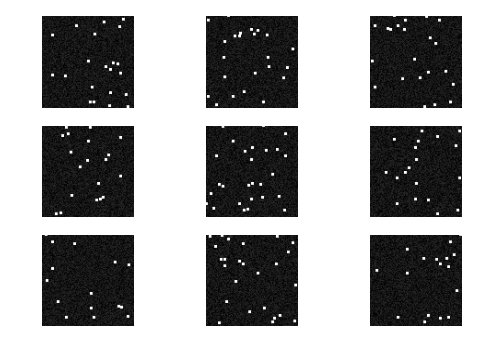

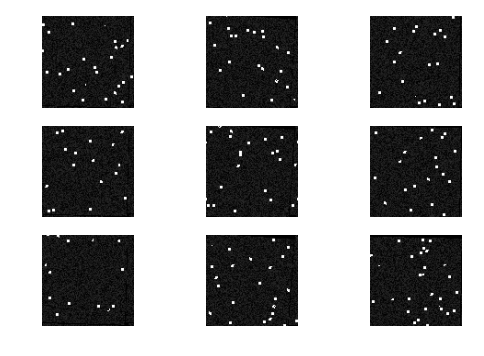

	Initial Error:  1.25079519242e+14


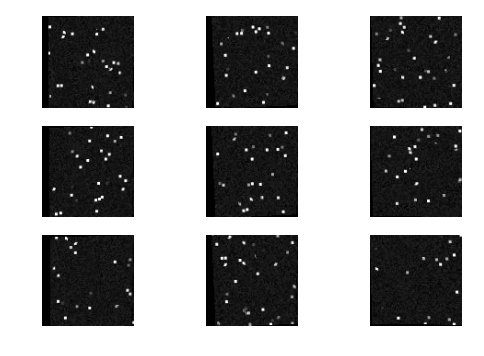

	Final Pipeline Error:  6.1499956405e+13
	Final Random Error:  1.23769425516e+14
	Pipeline Reduction Ratio:  0.508313137295
	Random Reduction Ratio:  0.0104740866766





Executing Test:  2
[[ 0.99746839 -0.0689779  -0.01728764 -1.43272206]
 [ 0.06883125  0.99758826 -0.00893965 -1.47391457]
 [ 0.01786258  0.00772708  0.99981059  1.11056363]
 [ 0.          0.          0.          1.        ]]


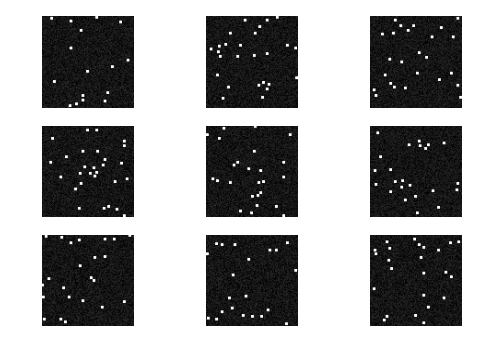

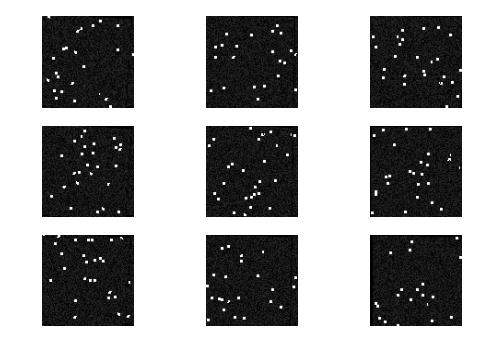

	Initial Error:  1.34302364274e+14


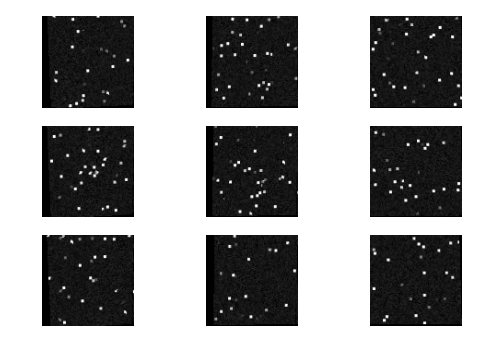

	Final Pipeline Error:  5.8531874752e+13
	Final Random Error:  1.31291966781e+14
	Pipeline Reduction Ratio:  0.564178374159
	Random Reduction Ratio:  0.0224150744372





Executing Test:  3
[[  9.99838490e-01   1.72535501e-04   1.79712033e-02  -1.01359249e+00]
 [  7.80435541e-05   9.99902806e-01  -1.39417309e-02   2.49939862e+00]
 [ -1.79718620e-02   1.39408817e-02   9.99741299e-01  -2.14323978e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


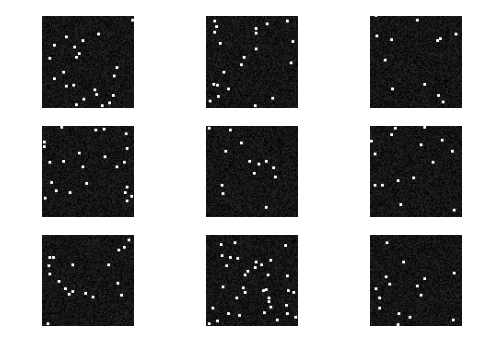

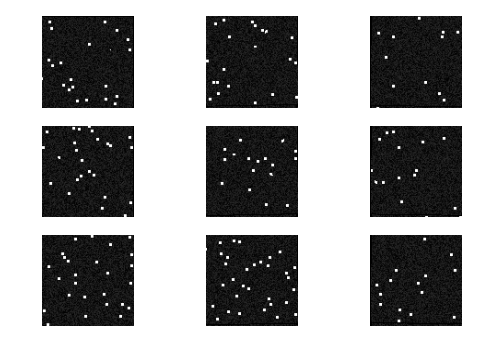

	Initial Error:  1.20568408417e+14


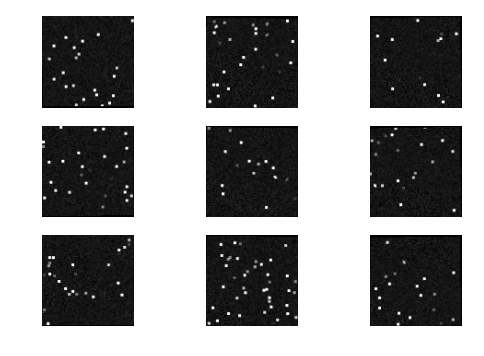

	Final Pipeline Error:  1.86161704748e+13
	Final Random Error:  1.22870276262e+14
	Pipeline Reduction Ratio:  0.845596614244
	Random Reduction Ratio:  -0.019091799214





Executing Test:  4
[[  9.98657083e-01   1.46123602e-02  -4.97042195e-02  -1.17288798e+00]
 [ -1.45299834e-02   9.99892397e-01   2.01827977e-03  -1.37366087e+00]
 [  4.97283630e-02  -1.29336790e-03   9.98761942e-01  -9.88675019e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


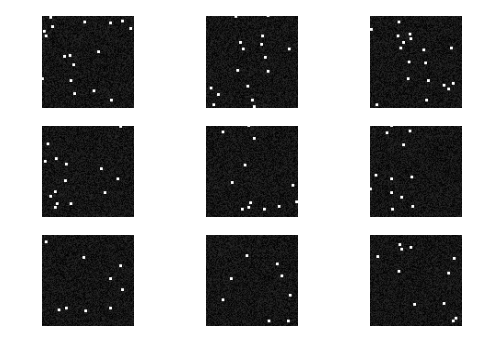

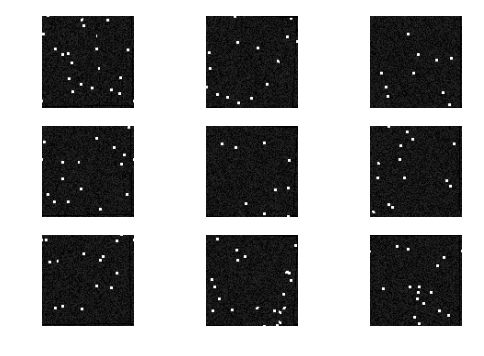

	Initial Error:  9.84930871234e+13


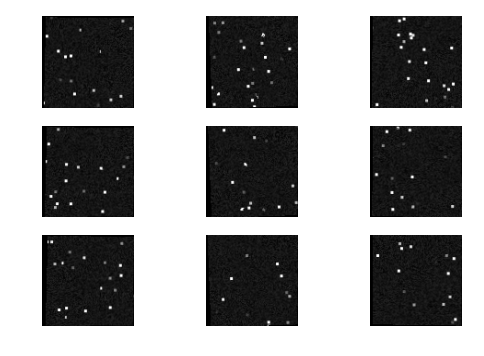

	Final Pipeline Error:  3.16551694827e+13
	Final Random Error:  9.92221269026e+13
	Pipeline Reduction Ratio:  0.67860516502
	Random Reduction Ratio:  -0.00740193855698





Executing Test:  5
[[ 0.99724583 -0.06042744  0.04300315 -0.86352828]
 [ 0.06109953  0.99802651 -0.01448875 -2.27096897]
 [-0.04204277  0.01707632  0.99896987 -1.41386597]
 [ 0.          0.          0.          1.        ]]


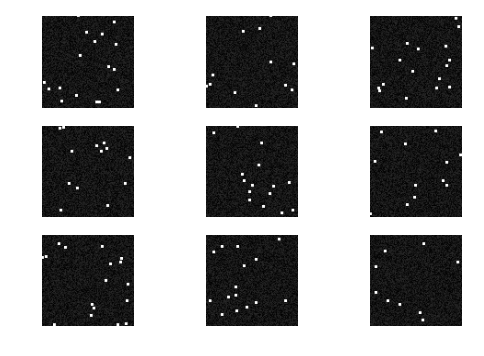

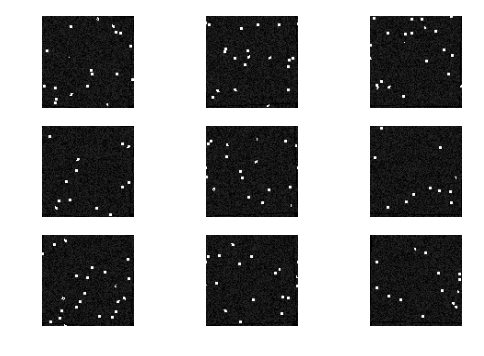

	Initial Error:  9.82893672251e+13


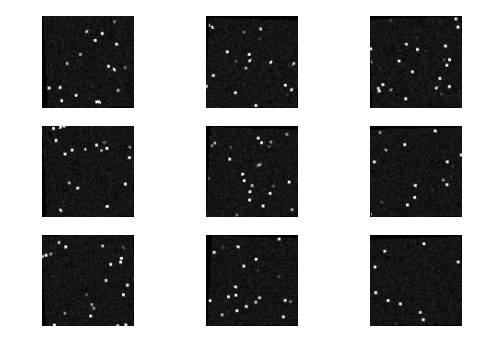

	Final Pipeline Error:  3.03193468222e+13
	Final Random Error:  9.73126607551e+13
	Pipeline Reduction Ratio:  0.691529738381
	Random Reduction Ratio:  0.00993705115355





Executing Test:  6
[[ 0.99959072  0.02594915 -0.01204336 -0.76948967]
 [-0.02633242  0.99911372 -0.03283881 -1.94365452]
 [ 0.01118055  0.0331425   0.9993881   2.16832205]
 [ 0.          0.          0.          1.        ]]


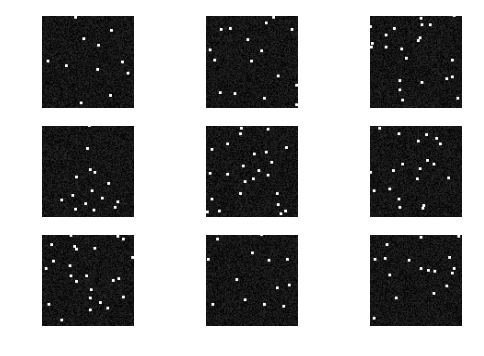

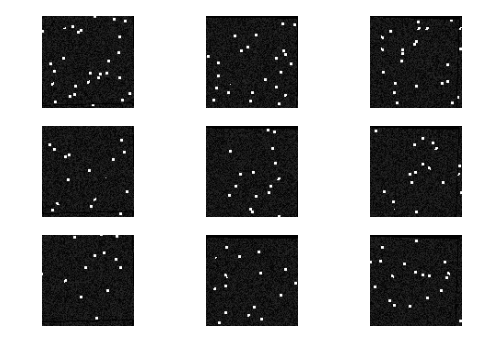

	Initial Error:  1.09082071368e+14


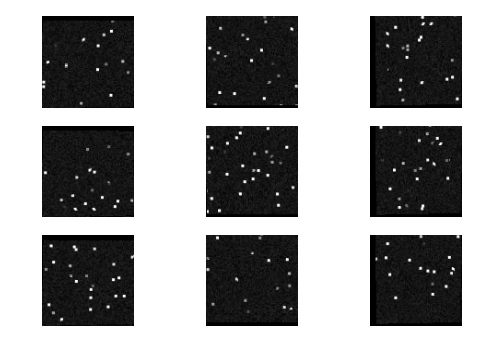

	Final Pipeline Error:  3.92067298322e+13
	Final Random Error:  1.07583852295e+14
	Pipeline Reduction Ratio:  0.640575858704
	Random Reduction Ratio:  0.0137347875251





Executing Test:  7
[[  9.98047995e-01   2.59583781e-03  -6.23976097e-02  -1.57955962e+00]
 [  1.57747139e-03   9.97769130e-01   6.67403609e-02  -2.11002689e+00]
 [  6.24316559e-02  -6.67085138e-02   9.95817384e-01   1.86394588e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


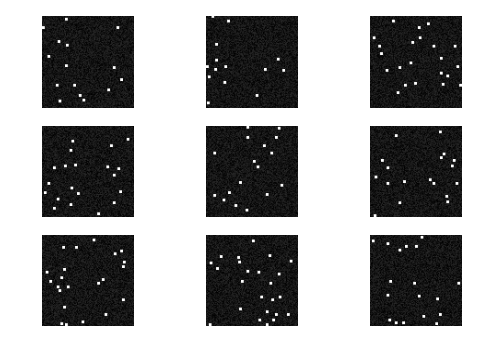

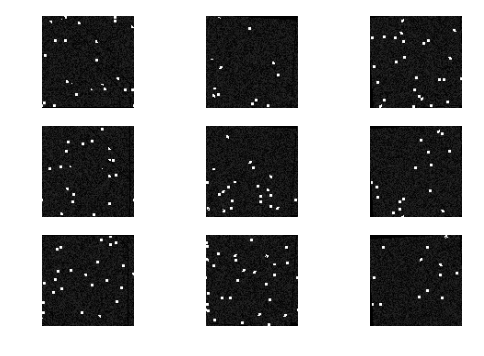

	Initial Error:  1.17140242381e+14


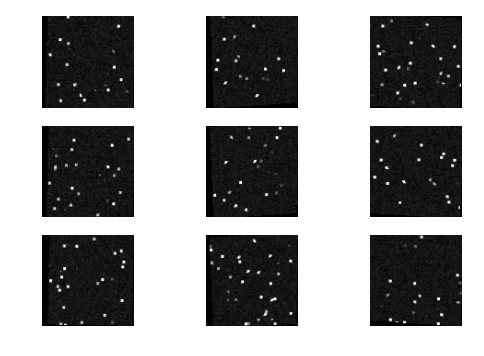

	Final Pipeline Error:  4.76468292528e+13
	Final Random Error:  1.16344523358e+14
	Pipeline Reduction Ratio:  0.59324969554
	Random Reduction Ratio:  0.00679287498785





Executing Test:  8
[[ 0.99859011 -0.01776897 -0.05002058  2.31636032]
 [ 0.0150005   0.99836329 -0.05518805 -0.39036127]
 [ 0.05091934  0.05435991  0.99722225 -0.89258113]
 [ 0.          0.          0.          1.        ]]


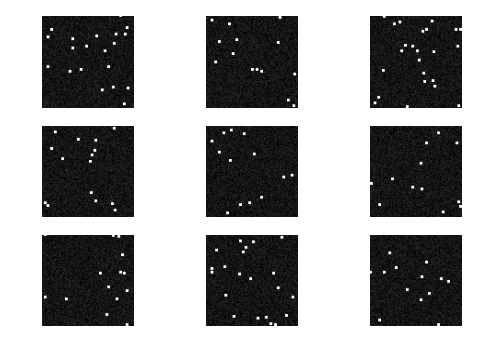

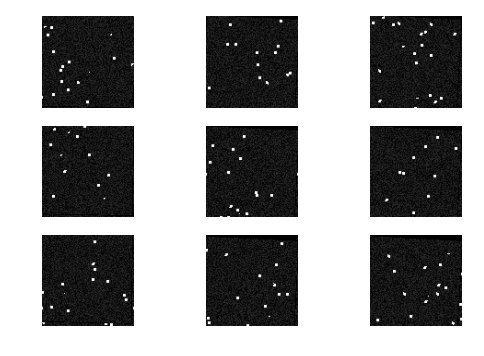

	Initial Error:  1.04137121836e+14


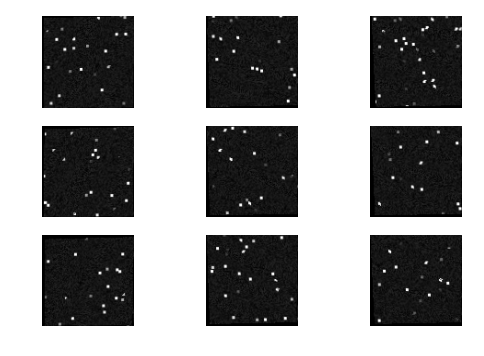

	Final Pipeline Error:  5.1894085313e+13
	Final Random Error:  1.02105692531e+14
	Pipeline Reduction Ratio:  0.501675441016
	Random Reduction Ratio:  0.0195072541821





Executing Test:  9
[[ 0.99843077  0.02205908 -0.05147232  1.07896473]
 [-0.02144261  0.99969195  0.01249855 -0.3484779 ]
 [ 0.05173217 -0.01137524  0.99859621 -1.64438137]
 [ 0.          0.          0.          1.        ]]


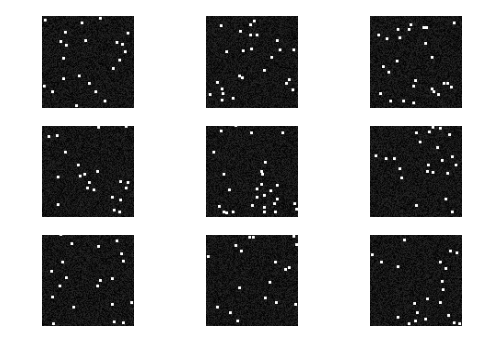

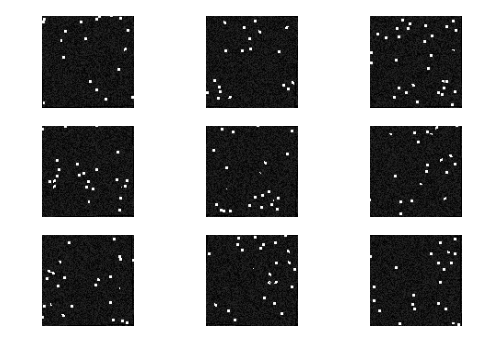

	Initial Error:  1.11133709736e+14


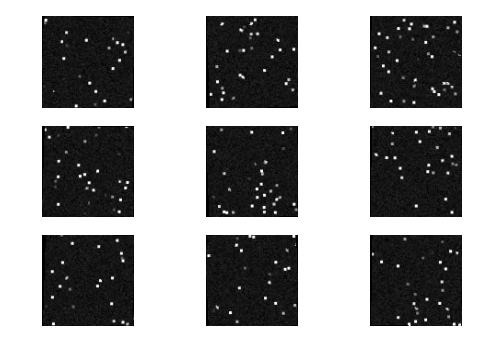

	Final Pipeline Error:  3.10906429343e+13
	Final Random Error:  1.24136953083e+14
	Pipeline Reduction Ratio:  0.720241113086
	Random Reduction Ratio:  -0.117005392674





Executing Test:  10
[[ 0.99781259  0.06283522 -0.02053715  0.21868635]
 [-0.06371362  0.99693698 -0.04535675 -2.38862871]
 [ 0.01762424  0.04656604  0.99875973  0.49366912]
 [ 0.          0.          0.          1.        ]]


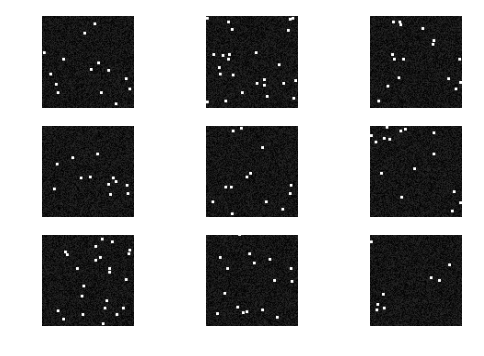

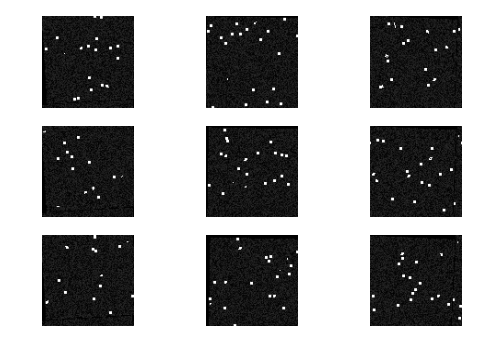

	Initial Error:  1.00965122959e+14


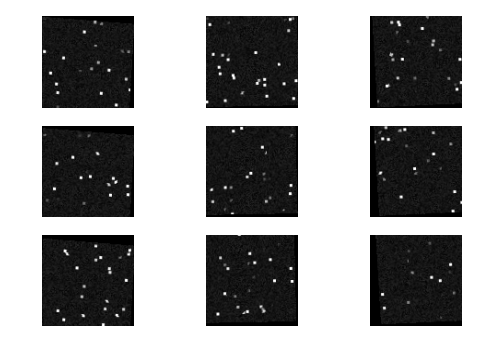

	Final Pipeline Error:  3.10091473765e+13
	Final Random Error:  1.00440732461e+14
	Pipeline Reduction Ratio:  0.69287268249
	Random Reduction Ratio:  0.00519377862948





Executing Test:  11
[[ 0.99864243 -0.04998708 -0.01464899  0.99544149]
 [ 0.04960536  0.998447   -0.02535553 -1.5373698 ]
 [ 0.01589368  0.02459444  0.99957116  0.35561775]
 [ 0.          0.          0.          1.        ]]


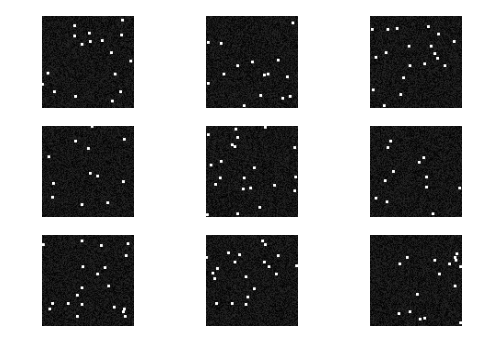

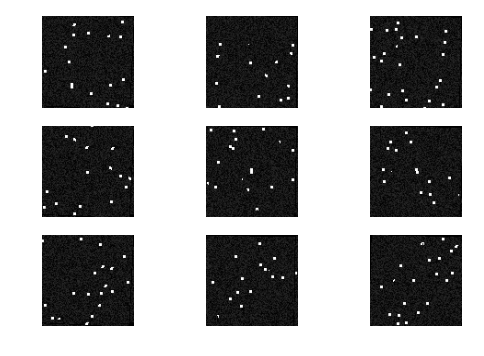

	Initial Error:  1.02909100716e+14


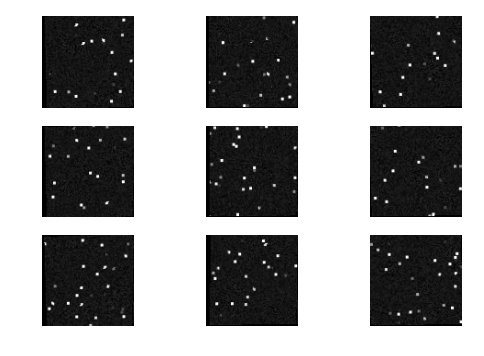

	Final Pipeline Error:  4.19807903488e+13
	Final Random Error:  1.09499381371e+14
	Pipeline Reduction Ratio:  0.592059496619
	Random Reduction Ratio:  -0.0640398235767





Executing Test:  12
[[ 0.99623589  0.06921861 -0.05218085  1.62915818]
 [-0.07237692  0.99549276 -0.06128419 -0.47138342]
 [ 0.04770365  0.0648302   0.99675544  0.23261963]
 [ 0.          0.          0.          1.        ]]


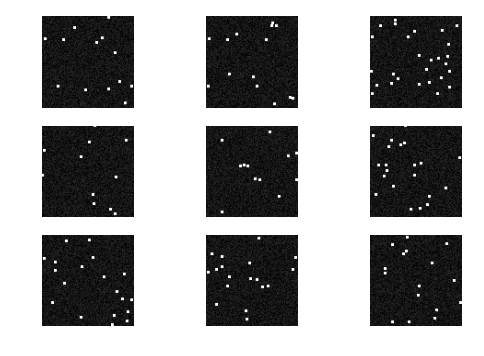

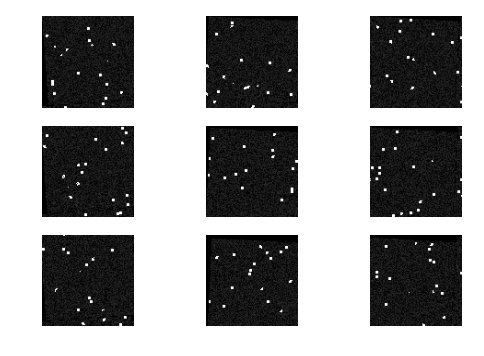

	Initial Error:  1.02920161965e+14


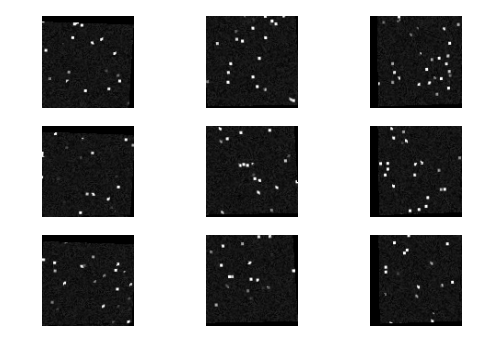

	Final Pipeline Error:  5.94763140101e+13
	Final Random Error:  1.02553939392e+14
	Pipeline Reduction Ratio:  0.422112121914
	Random Reduction Ratio:  0.00355831710406





Executing Test:  13
[[ 0.997512    0.06065319 -0.03593057  1.18042196]
 [-0.05850812  0.99659991  0.05801226 -0.16129565]
 [ 0.03932703 -0.05576569  0.99766907  1.13116851]
 [ 0.          0.          0.          1.        ]]


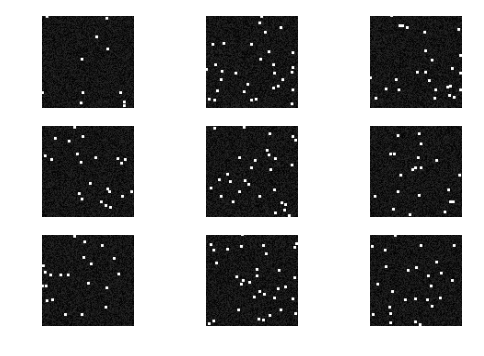

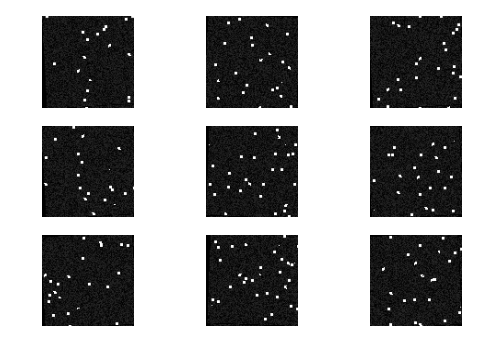

	Initial Error:  1.26966068454e+14


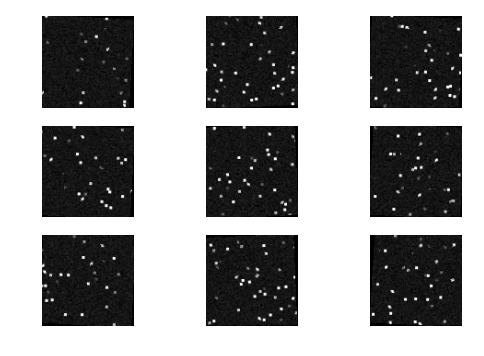

	Final Pipeline Error:  2.61581976445e+13
	Final Random Error:  1.30700298005e+14
	Pipeline Reduction Ratio:  0.793974894529
	Random Reduction Ratio:  -0.0294112403166





Executing Test:  14
[[ 0.99851816  0.04923179  0.02318888  0.13469521]
 [-0.04932268  0.99877723  0.00336379 -1.75310833]
 [-0.02299492 -0.00450255  0.99972544 -0.61285605]
 [ 0.          0.          0.          1.        ]]


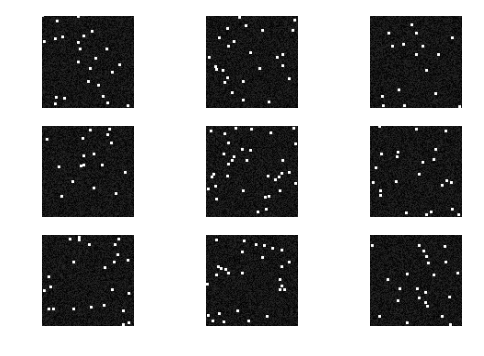

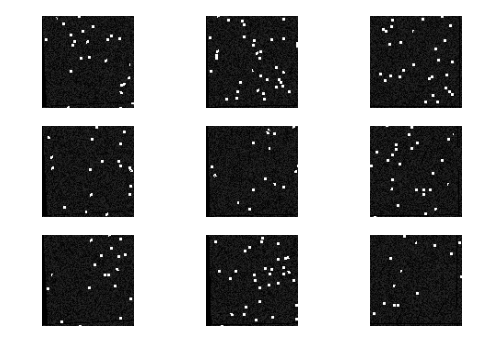

	Initial Error:  1.38485870647e+14


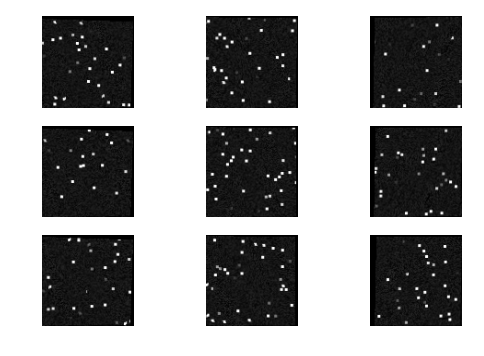

	Final Pipeline Error:  5.56839235666e+13
	Final Random Error:  1.35116024462e+14
	Pipeline Reduction Ratio:  0.597908990236
	Random Reduction Ratio:  0.0243335018226





Executing Test:  15
[[ 0.99810486 -0.05898499  0.01753465 -2.28592888]
 [ 0.05912958  0.99821949 -0.00784476  0.63599836]
 [-0.01704071  0.00886671  0.99981548  1.32090537]
 [ 0.          0.          0.          1.        ]]


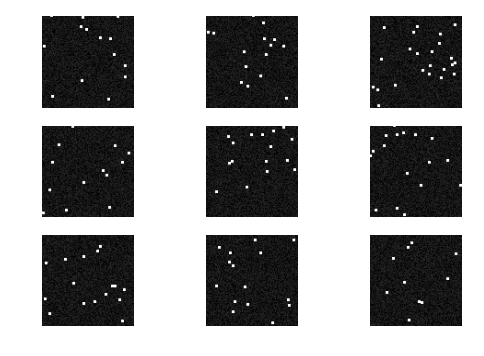

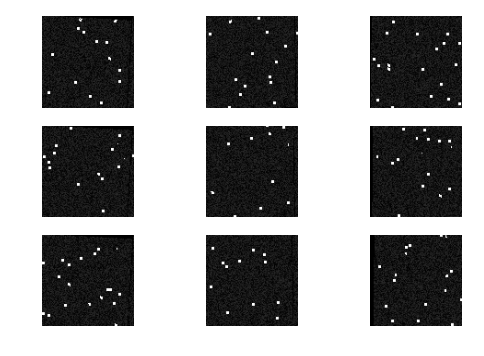

	Initial Error:  9.85455442978e+13


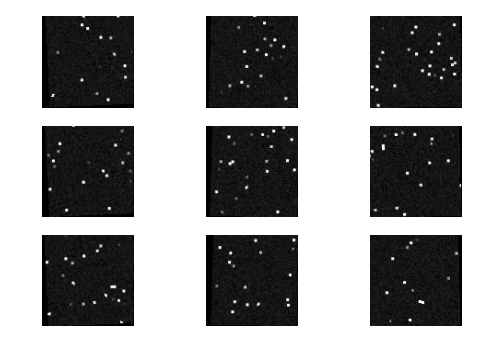

	Final Pipeline Error:  3.37746855444e+13
	Final Random Error:  9.92972602201e+13
	Pipeline Reduction Ratio:  0.657268263267
	Random Reduction Ratio:  -0.00762810665538





Executing Test:  16
[[ 0.99805319 -0.05466411  0.03002779  1.96118734]
 [ 0.05638046  0.99662615 -0.05964525  1.55363607]
 [-0.02666602  0.06122211  0.9977679  -0.2955178 ]
 [ 0.          0.          0.          1.        ]]


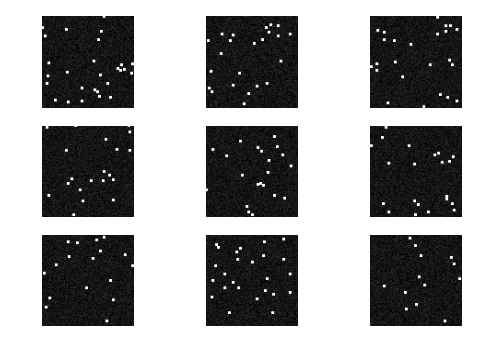

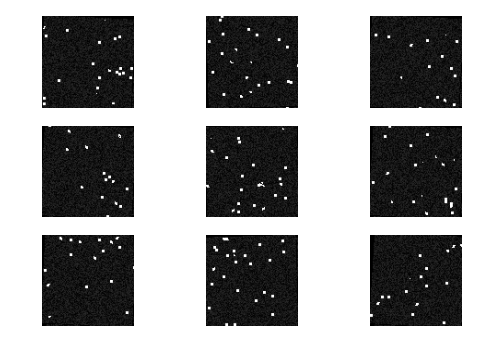

	Initial Error:  1.13148558665e+14


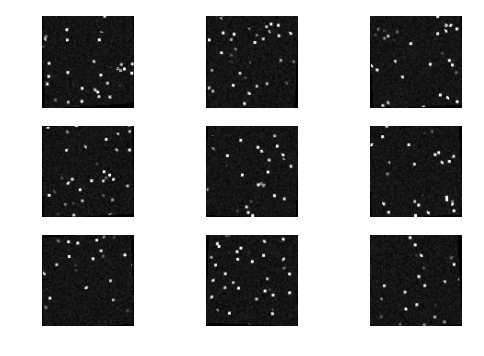

	Final Pipeline Error:  3.11135762949e+13
	Final Random Error:  1.22823311965e+14
	Pipeline Reduction Ratio:  0.725020126974
	Random Reduction Ratio:  -0.0855048744239





Executing Test:  17
[[ 0.99807435 -0.05580289  0.02708562  0.42776719]
 [ 0.05634282  0.99821912 -0.01959775  1.65981999]
 [-0.02594377  0.02108609  0.99944099 -0.03961783]
 [ 0.          0.          0.          1.        ]]


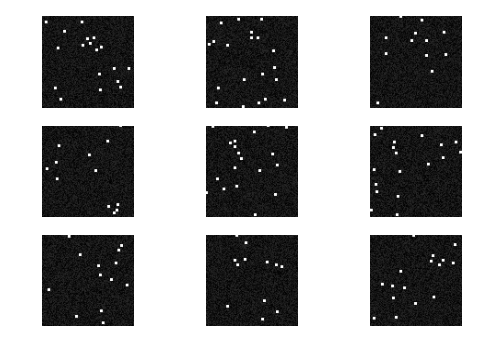

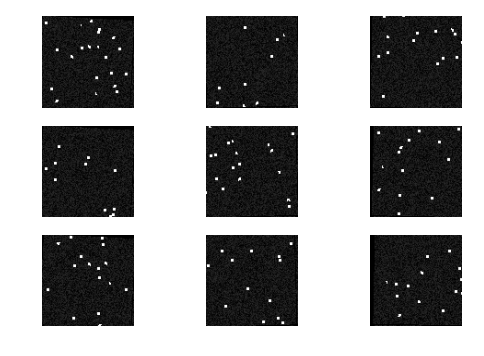

	Initial Error:  8.82067705132e+13


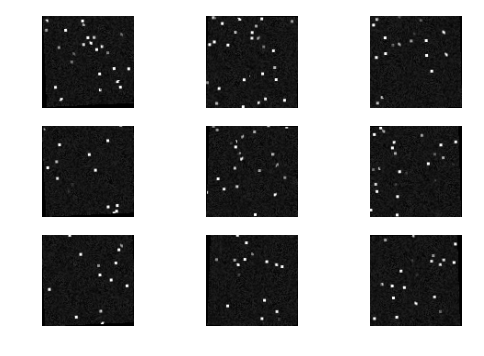

	Final Pipeline Error:  2.49463714935e+13
	Final Random Error:  9.53333466998e+13
	Pipeline Reduction Ratio:  0.717183030868
	Random Reduction Ratio:  -0.0807939815181





Executing Test:  18
[[ 0.99727025 -0.06977133 -0.02416631 -0.87893806]
 [ 0.06803356  0.99546439 -0.06649869 -2.13579881]
 [ 0.0286964   0.06467304  0.99749382 -1.40810112]
 [ 0.          0.          0.          1.        ]]


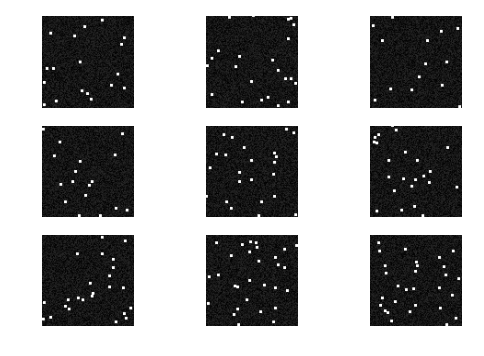

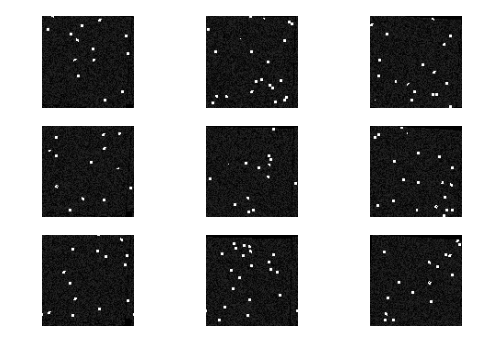

	Initial Error:  1.16688278184e+14


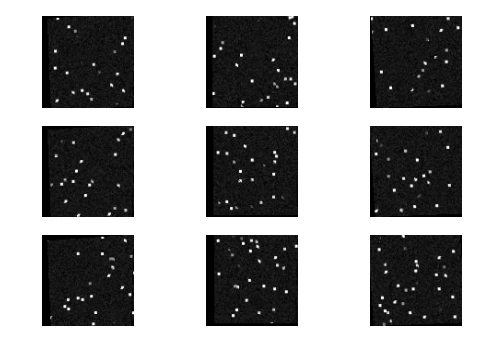

	Final Pipeline Error:  5.58857679847e+13
	Final Random Error:  1.15525931605e+14
	Pipeline Reduction Ratio:  0.521067849707
	Random Reduction Ratio:  0.00996112546594





Executing Test:  19
[[ 0.99668905 -0.04115825  0.07012081  2.04225533]
 [ 0.04490937  0.99759551 -0.05278586 -1.43473137]
 [-0.06777963  0.05576017  0.99614092 -1.6239974 ]
 [ 0.          0.          0.          1.        ]]


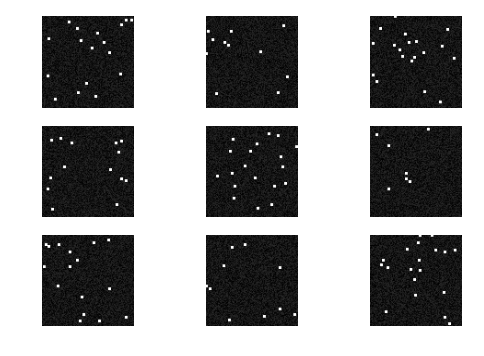

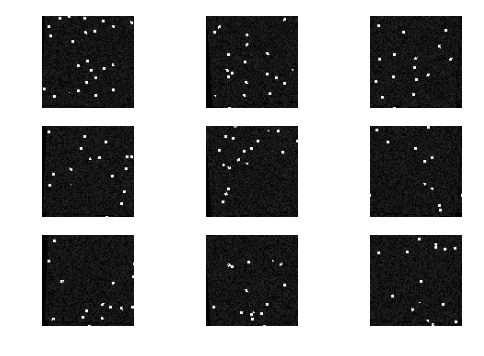

	Initial Error:  1.0411600808e+14


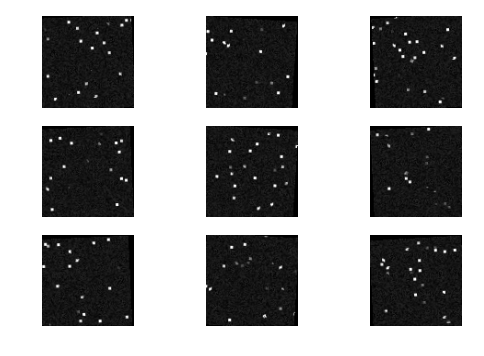

	Final Pipeline Error:  2.04790076311e+13
	Final Random Error:  1.05576667343e+14
	Pipeline Reduction Ratio:  0.803305869974
	Random Reduction Ratio:  -0.0140291516125





Executing Test:  20
[[ 0.99891636 -0.01725331 -0.04322527  1.19723732]
 [ 0.01445308  0.99782741 -0.0642773  -1.95877907]
 [ 0.04424036  0.0635829   0.99699549  1.18013888]
 [ 0.          0.          0.          1.        ]]


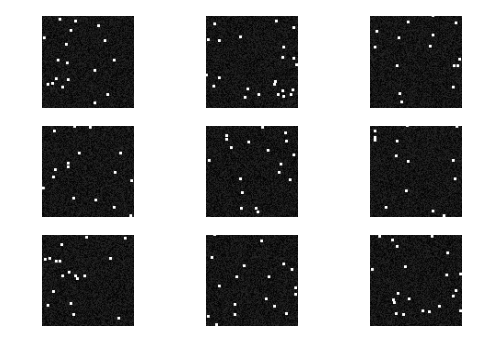

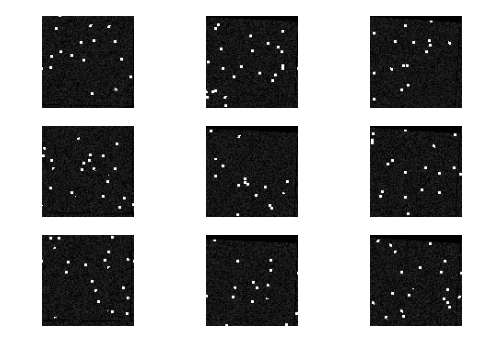

	Initial Error:  1.09238269083e+14


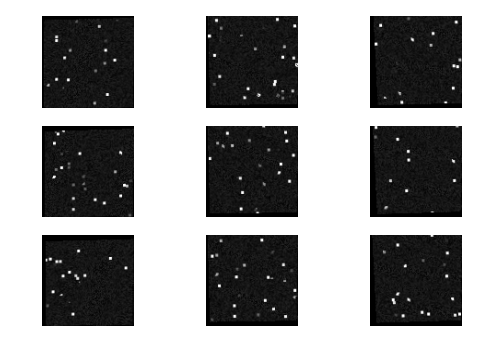

	Final Pipeline Error:  5.54842618441e+13
	Final Random Error:  1.08816372099e+14
	Pipeline Reduction Ratio:  0.492080364235
	Random Reduction Ratio:  0.00386217199591





Average Error Reduction Ratio:
	Pipeline:  0.637940941413
	Random:  -0.0147568142284

Error Reduction Ratio Variance
	Pipeline:  0.012570300783
	Random:  0.00154431282274


In [5]:
pipelineDat = []
randDat = []
errorList = []

for i in range(20):
    print '\nExecuting Test: ', i+1
    
    #generate an display data
    itkVolume, rigidVolume, curTransform = generateTestVolume()
    print curTransform
    ndreg.imgShow(itkVolume, vmax=60000)
    ndreg.imgShow(rigidVolume, vmax=60000)
    
    #calculate initial error
    initialErr = np.sum((itk.GetArrayFromImage(itkVolume)-itk.GetArrayFromImage(rigidVolume))**2)
    print '\tInitial Error: ', initialErr
    
    #perform transform
    transform = register(rigidVolume, itkVolume)
    resultVolume = ndreg.imgApplyAffine(rigidVolume, transform, size=itkVolume.GetSize(), spacing=itkVolume.GetSpacing())
    ndreg.imgShow(resultVolume, vmax=60000)
    #perform random transform
    randMatrix = applyRigid(itk.GetArrayFromImage(rigidVolume), getTransform())

    
    #calculate final error
    finalPipeErr = np.sum((itk.GetArrayFromImage(itkVolume)-itk.GetArrayFromImage(resultVolume))**2)
    finalRandErr = np.sum((itk.GetArrayFromImage(itkVolume)-randMatrix)**2)
    print '\tFinal Pipeline Error: ', finalPipeErr
    print '\tFinal Random Error: ', finalRandErr

    #get the reduction in error
    pipeRatio = (initialErr - finalPipeErr)/initialErr 
    randRatio = (initialErr - finalRandErr)/initialErr 
    pipelineDat.append(pipeRatio)
    randDat.append(randRatio)
    errorList.append(initialErr)
    
    print '\tPipeline Reduction Ratio: ', pipeRatio
    print '\tRandom Reduction Ratio: ', randRatio
    print '\n\n\n'
    
print '\nAverage Error Reduction Ratio:'
print '\tPipeline: ', np.average(pipelineDat)
print '\tRandom: ', np.average(randDat)

print '\nError Reduction Ratio Variance'
print '\tPipeline: ', np.var(pipelineDat)
print '\tRandom: ', np.var(randDat)

    


#### 3. Analyze Results
There is an interestingly high variance in the NDReg pipeline's performance. I graphed the reduction ratio in a histogram below to demonstrate this observation.

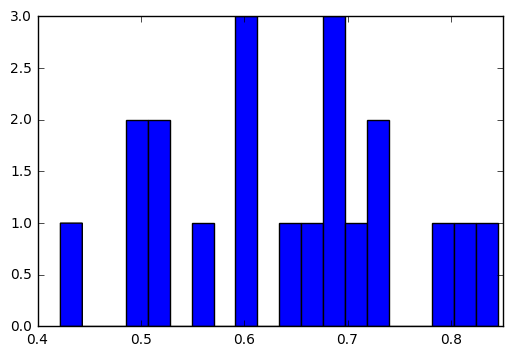

In [6]:
import matplotlib.pyplot as plt
plt.hist(pipelineDat, 20)
plt.show()

There is an obvious bimodal tendency to the distribution of these results. I am not yet sure what may be causing these highly variant results, but I will continue to investigate. I intend to show these to Kwame on Tuesday during our meeting in hope that he can shed some light on what the cause may be.

In terms of performance, the algorithm does perform far better than random. However, the error reduction rate is substantially skiewed by the 8 extremely low scores in the test results. My initial thought is that the pipeline's error reduction rate may be based on the magnitude of the initial error. Below is a graph of error reduction rate vs the initial error.

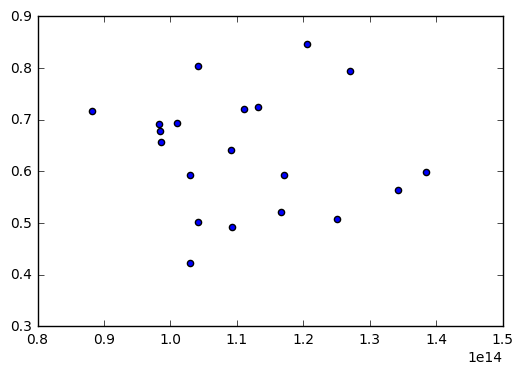

In [7]:
plt.scatter(errorList, pipelineDat)
plt.show()


The nonlinear nature of the scatter plot is evidence that there is some other source of noise causing poor performance in NDReg beyond magnitude of initial error. It is my hope that my meeting with Kwame on Tuesday will allow me to gain some intuition as to what this lurking variable may be.